<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/main/fyp_transformer_netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pandas-ta

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import yfinance as yf

In [5]:
# Load historical stock data (date, closing price) into a pandas DataFrame
df = yf.download(tickers=['NFLX'], start='2012-01-01', end='2022-06-20')
data = df.dropna()


[*********************100%***********************]  1 of 1 completed


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2012-01-03 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2633 non-null   float64
 1   High       2633 non-null   float64
 2   Low        2633 non-null   float64
 3   Close      2633 non-null   float64
 4   Adj Close  2633 non-null   float64
 5   Volume     2633 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 144.0 KB


In [7]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,10.040000,10.388571,10.018571,10.320000,10.320000,29213800
2012-01-04,10.335714,11.567143,10.258571,11.492857,11.492857,100489900
2012-01-05,11.345714,11.694286,11.040000,11.328571,11.328571,86552900
2012-01-06,11.302857,12.471429,11.242857,12.327143,12.327143,125610800
2012-01-09,12.801429,14.235714,12.448571,14.025714,14.025714,214073300
...,...,...,...,...,...,...
2022-06-13,177.070007,179.089996,168.960007,169.690002,169.690002,10222400
2022-06-14,169.750000,172.059998,164.279999,167.539993,167.539993,11555300
2022-06-15,169.259995,183.850006,168.529999,180.110001,180.110001,12396000


In [8]:
data.shape

(2633, 6)

In [9]:
# Adding indicators
import pandas_ta as ta
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)


<ipython-input-9-b4b30b35953b>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]


In [10]:
data_set = data.iloc[:, 0:11]
pd.set_option('display.max_columns', None)

data_set.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS
0,2012-08-06,7.791429,8.167143,7.730000,8.112857,8.112857,28527800,33.687547,9.326657,11.581611,12.993457
1,2012-08-07,8.135714,8.495714,8.078571,8.271429,8.271429,30769900,35.851662,9.226159,11.516063,12.930914
2,2012-08-08,8.224286,8.412857,8.167143,8.257143,8.257143,18194400,35.739078,9.133872,11.451530,12.869009
3,2012-08-09,8.227143,8.350000,8.178571,8.272857,8.272857,16492700,35.976018,9.051871,11.388586,12.808133
4,2012-08-10,8.237143,8.651429,8.128571,8.557143,8.557143,35032200,40.246686,9.004754,11.332518,12.751829
5,2012-08-13,8.745714,8.750000,8.357143,8.558571,8.558571,33324900,40.268124,8.962260,11.277588,12.696289
6,2012-08-14,8.660000,9.014286,8.567143,8.822857,8.822857,48119400,44.236321,8.948984,11.228979,12.644985
7,2012-08-15,8.861429,9.097143,8.831429,9.037143,9.037143,30844100,47.278980,8.957380,11.185577,12.597199
8,2012-08-16,9.065714,9.227143,8.971429,9.187143,9.187143,17630900,49.351648,8.979262,11.146004,12.552033
9,2012-08-17,9.268571,9.360000,9.072857,9.098571,9.098571,22405600,48.153950,8.990625,11.105460,12.506292


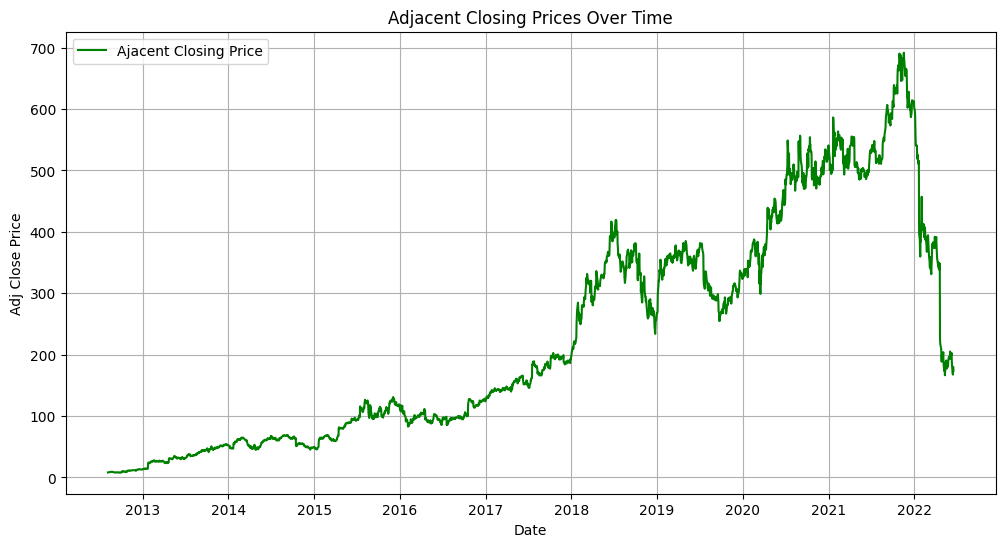

In [13]:
# Plot the  Ajacent closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Adj Close'], label='Ajacent Closing Price', color='green')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Adjacent Closing Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

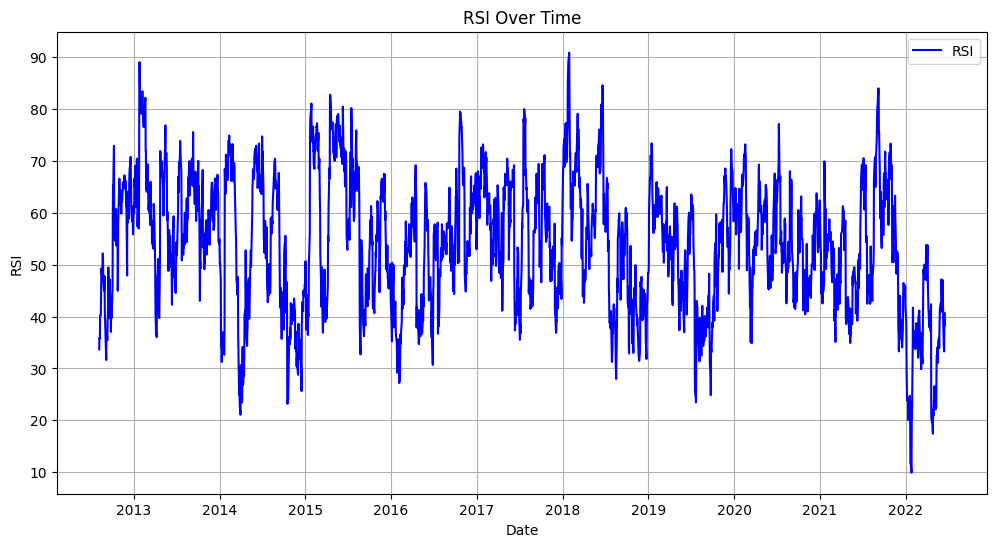

In [12]:
# Plot additional indicator Such as RSI
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['RSI'], label='RSI', color='blue')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI Over Time')
plt.legend()
plt.grid(True)
plt.show()


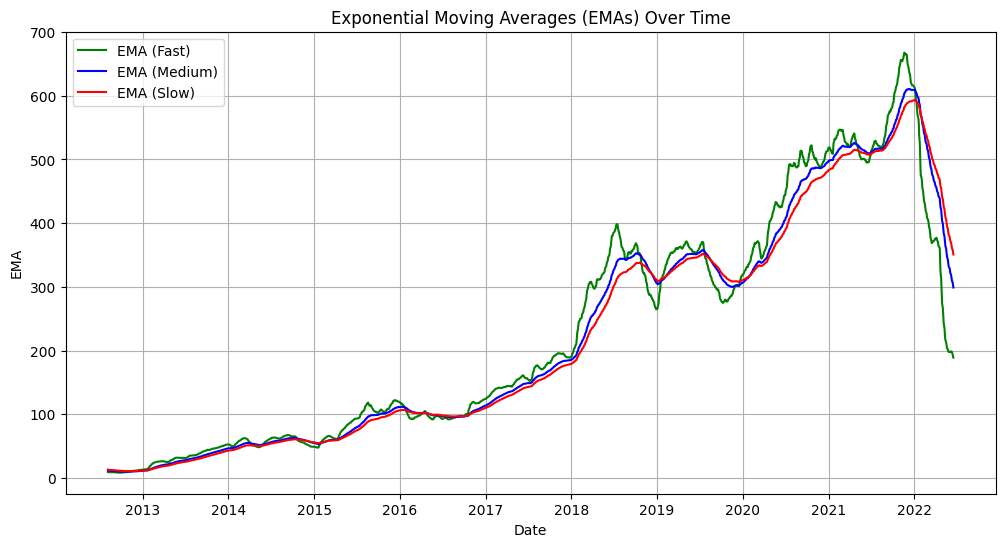

In [14]:
# Plot additional indicators such as EMAF, EMAM, EMAF
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['EMAF'], label='EMA (Fast)', color='green')
plt.plot(data['Date'], data['EMAM'], label='EMA (Medium)', color='blue')
plt.plot(data['Date'], data['EMAS'], label='EMA (Slow)', color='red')
plt.xlabel('Date')
plt.ylabel('EMA')
plt.title('Exponential Moving Averages (EMAs) Over Time')
plt.legend()
plt.grid(True)
plt.show()


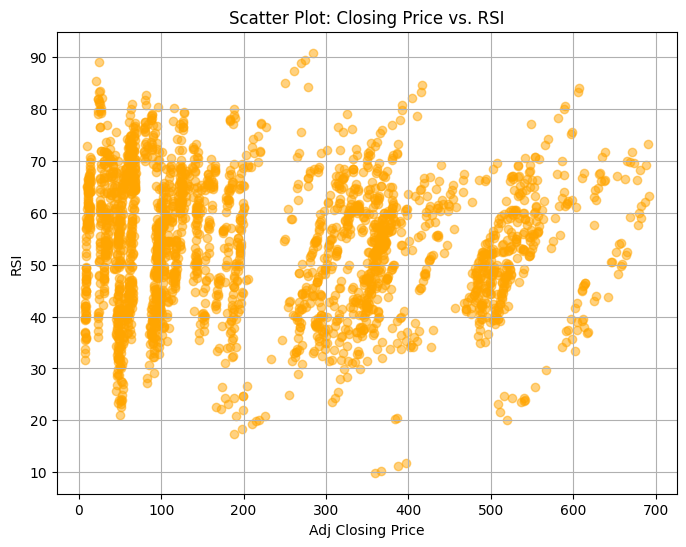

In [15]:
# Scatter plot between closing price and RSI
plt.figure(figsize=(8, 6))
plt.scatter(data['Adj Close'], data['RSI'], alpha=0.5, color='orange')
plt.xlabel('Adj Closing Price')
plt.ylabel('RSI')
plt.title('Scatter Plot: Closing Price vs. RSI')
plt.grid(True)
plt.show()

In [16]:
# Dropping columns
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close','Date'], axis=1, inplace=True)

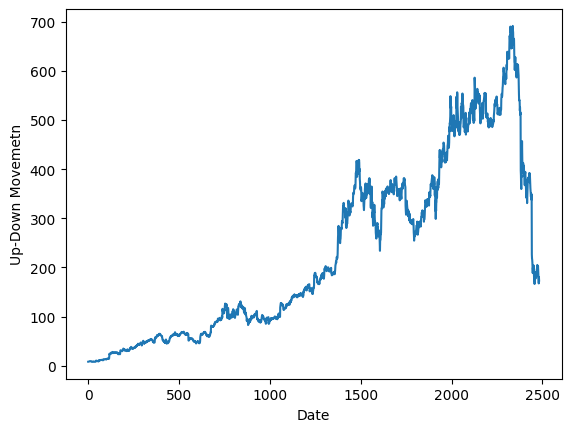

In [17]:
import matplotlib.pyplot as plt
data_set_AC=data_set['Adj Close']
plt.ylabel('Up-Down Movemetn')
plt.xlabel('Date')
plt.plot(data_set_AC)

In [18]:
# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data)

In [19]:
# Prepare the data for training
X, y = [], []
backcandles = 20
for i in range(backcandles, data_set_scaled.shape[0]):
    X.append(data_set_scaled[i - backcandles:i, :-1])
    y.append(data_set_scaled[i, -1])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Build the Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention mechanism
    attn_output = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward neural network
    ffn_output = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attn_output)
    ffn_output = tf.keras.layers.Dropout(dropout)(ffn_output)
    ffn_output = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ffn_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

In [21]:
# Build the Transformer model
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
):
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

In [22]:
input_shape = X_train.shape[1:]
head_size = 128
num_heads = 4
ff_dim = 32
num_transformer_blocks = 8
mlp_units = [64, 32]

In [23]:
# Create and compile the Transformer model
model = build_transformer_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.25,
)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


In [24]:
# Training the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=128,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 815ms/step - loss: 0.1461 - mean_absolute_error: 0.2831 - val_loss: 0.0136 - val_mean_absolute_error: 0.0848
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0299 - mean_absolute_error: 0.1289 - val_loss: 0.0090 - val_mean_absolute_error: 0.0693
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0220 - mean_absolute_error: 0.1102 - val_loss: 0.0035 - val_mean_absolute_error: 0.0420
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0167 - mean_absolute_error: 0.0957 - val_loss: 0.0046 - val_mean_absolute_error: 0.0494
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0147 - mean_absolute_error: 0.0887 - val_loss: 0.0090 - val_mean_absolute_error: 0.0778
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0139 - mean_absolute_error: 0.0848 - val_loss: 0.0036 - val_mean_absolute_error: 0.0483
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0094 - mean_absolute_error: 0.0704 -

In [25]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.083794,0.208828,0.013618,0.084812
1,0.028019,0.124780,0.008963,0.069311
2,0.021517,0.108716,0.003461,0.041962
3,0.015835,0.092573,0.004592,0.049379
4,0.014430,0.089218,0.008954,0.077766


<Axes: >

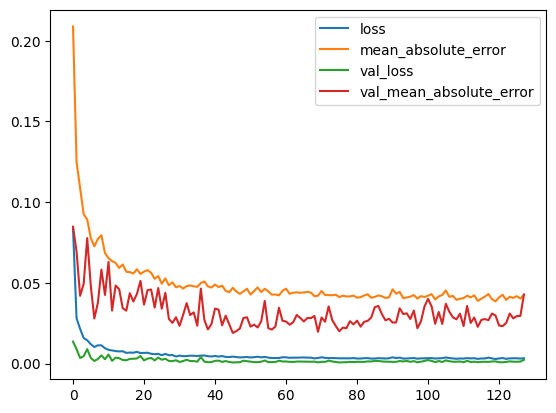

In [26]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 11)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 20, 11)         │         24,075 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 11)         │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 20, 11)         │             22 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 32)         │            384 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 20, 11)         │            363 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 11)         │              0 │ layer_normalization[0… │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 20, 11)         │             22 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 20, 11)         │         24,075 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 20, 11)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 20, 11)         │             22 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 20, 32)         │            384 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 20, 11)         │            363 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 605,429 (2.31 MB)

 Trainable params: 201,809 (788.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,620 (1.54 MB)

In [28]:
# Make predictions
y_pred = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0428
Mean Squared Error (MSE): 0.0024
Root Mean Squared Error (RMSE): 0.0485
R-squared (R2) score: 0.9642


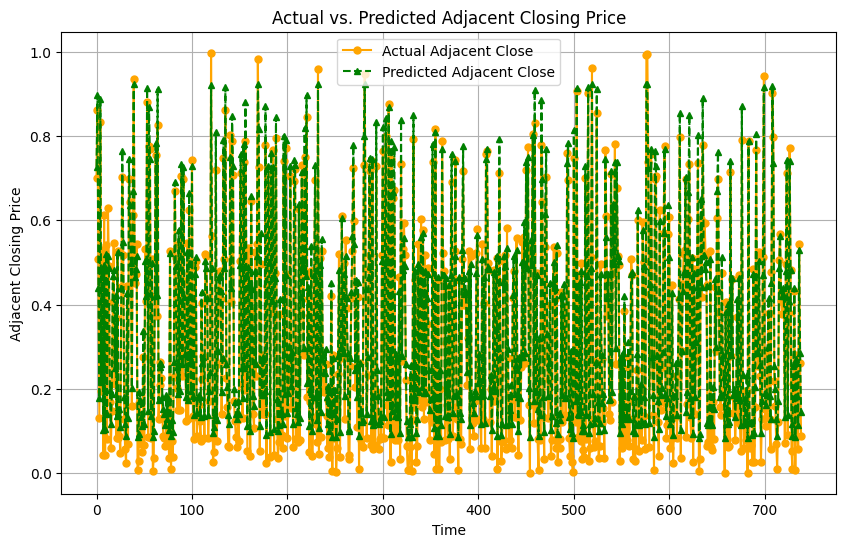

In [30]:
# Plot the actual and predicted adjacent closing prices
# Assuming y_test and y_pred are numpy arrays
y_test = y_test.squeeze()
y_pred = y_pred.squeeze()

plt.figure(figsize=(10, 6))  # Increase figure size for better visibility

# Plot actual values as blue circles
plt.plot(y_test, label='Actual Adjacent Close', color='orange', marker='o', linestyle='-', markersize=5)

# Plot predicted values as red triangles
plt.plot(y_pred, label='Predicted Adjacent Close', color='green', marker='^', linestyle='--', markersize=5)

plt.xlabel('Time')
plt.ylabel('Adjacent Closing Price')
plt.title('Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

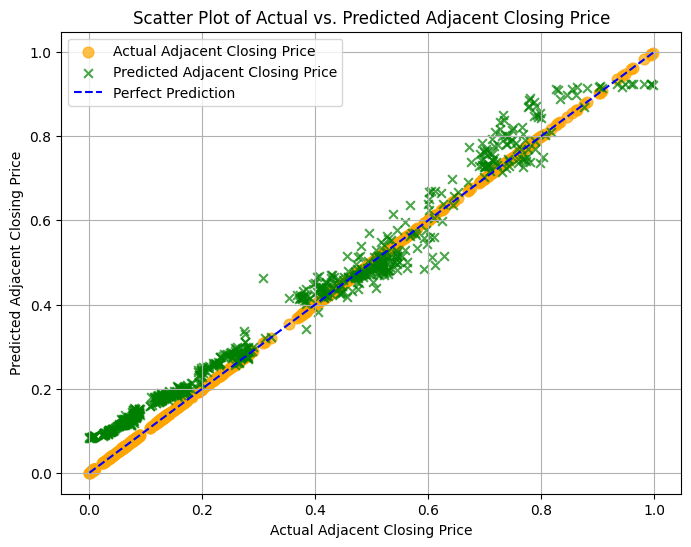

In [31]:
# Scatter plot of actual vs. predicted adjacent closing prices
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

# Plot actual values as orange circles with larger markers
plt.scatter(y_test, y_test, color='orange', label='Actual Adjacent Closing Price', alpha=0.7, s=60)

# Plot predicted values as black crosses with smaller markers
plt.scatter(y_test, y_pred, color='green', label='Predicted Adjacent Closing Price', alpha=0.7, s=40, marker='x')

# Plot the diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Adjacent Closing Price')
plt.ylabel('Predicted Adjacent Closing Price')
plt.title('Scatter Plot of Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

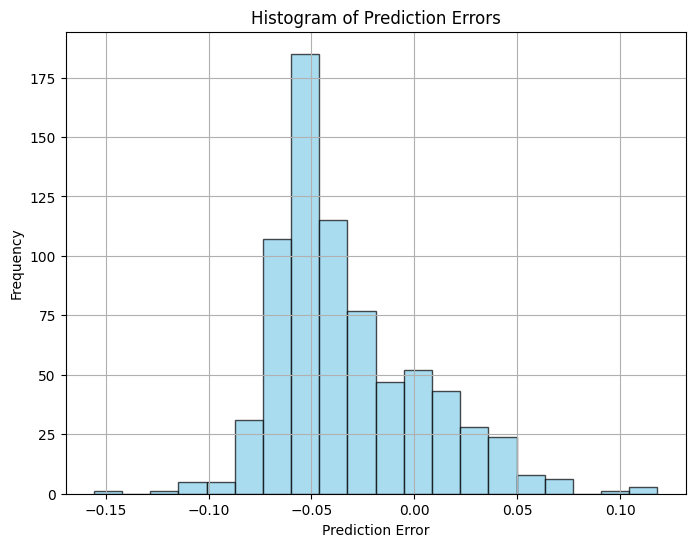

In [32]:
# Histogram of prediction errors
errors = y_test - y_pred

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add grid lines for better readability
plt.grid(True)

plt.show()


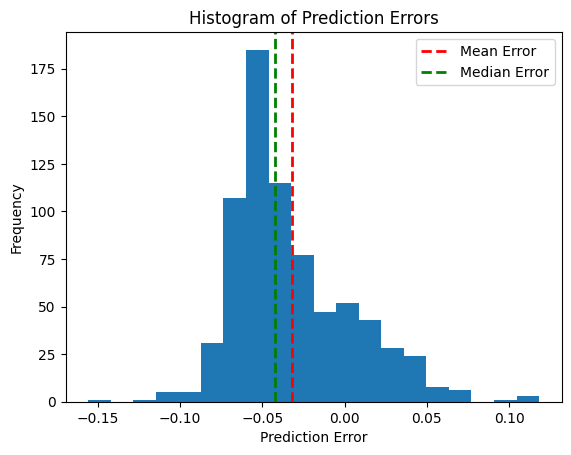

In [33]:
# Histogram of prediction errors
errors = y_test - y_pred
plt.hist(errors, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Calculate mean and median of prediction errors
mean_error = np.mean(errors)
median_error = np.median(errors)

# Add lines for mean and median on the histogram
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label='Mean Error')
plt.axvline(median_error, color='green', linestyle='dashed', linewidth=2, label='Median Error')

plt.legend()
plt.show()


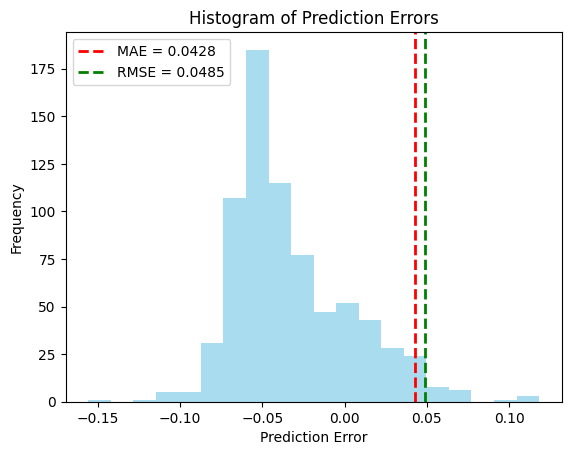

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate prediction errors
errors =y_test - y_pred

# Calculate mean absolute error (MAE) and root mean squared error (RMSE)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Histogram of prediction errors
plt.hist(errors, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add lines for MAE and RMSE on the histogram
plt.axvline(mae, color='red', linestyle='dashed', linewidth=2, label=f'MAE = {mae:.4f}')
plt.axvline(rmse, color='green', linestyle='dashed', linewidth=2, label=f'RMSE = {rmse:.4f}')

plt.legend()
plt.show()
